# File and libraries

In [117]:
import pandas as pd
import numpy as np


file_tag = "Google Merch Store 2024-2025"


# DSLabs functions

In [118]:
%run "scripts/dslabs_functions.py"


# Data functions

In [119]:
%run "scripts/data_functions.py"


data_functions loaded


# Load

In [120]:
test_data=True
# test_data=False


train=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_train.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)

test=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_test.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)

target='Sessions'

# Prepare the training and testing data
trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 318 entries, 2024-01-06 to 2024-11-18
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sessions                         318 non-null    float64
 1   Seven-day active users           318 non-null    float64
 2   28-day active users              318 non-null    float64
 3   Events per session               318 non-null    float64
 4   Add to baskets                   318 non-null    float64
 5   Checkouts                        318 non-null    float64
 6   E-commerce purchases             318 non-null    float64
 7   Average purchase revenue         318 non-null    float64
 8   Purchase revenue                 318 non-null    float64
 9   Average session duration         318 non-null    float64
 10  ARPU                             318 non-null    float64
 11  ARPPU                            318 non-null    float64
 12  Vie

# ARIMA Univariate

## ARIMA Study

ARIMA best results achieved with (p,d,q)=(7, 0, 5) ==> measure=0.04


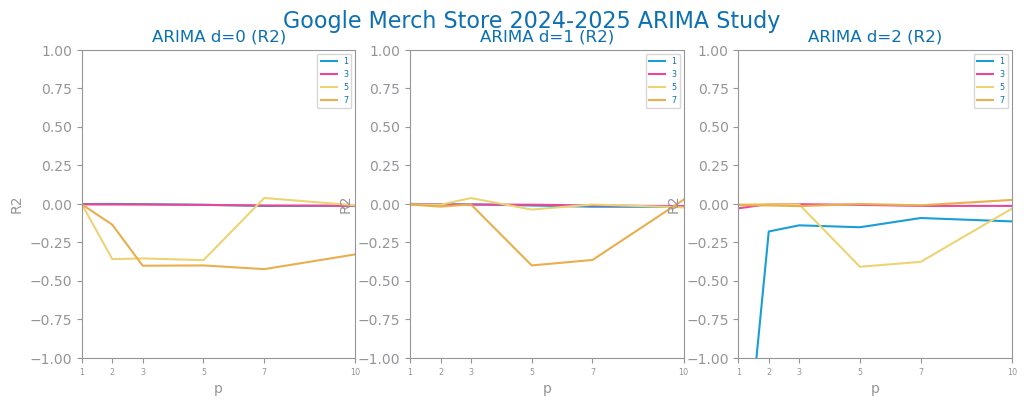

In [121]:
from matplotlib.pyplot import figure, savefig, subplots
import warnings
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart
from pandas import Series
from numpy import isfinite
from matplotlib.pyplot import savefig


def arima_uni_study(train: Series, test: Series, measure: str = "R2", freq: str = None):
    # Ensure data does not contain NaN or infinite values
    train = train[isfinite(train)]
    test = test[isfinite(test)]

    # Set frequency if provided
    if freq:
        train = train.asfreq(freq)
        test = test.asfreq(freq)

    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    fig.suptitle(f"{file_tag} ARIMA Study", fontsize=16)  # Add subtitle over the charts      
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                try:
                    arima = ARIMA(train, order=(p, d, q))
                    model = arima.fit(method_kwargs={"maxiter": 500})  # Increase the number of iterations
                    prd_tst = model.forecast(steps=len(test), signal_only=False)
                    eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                    # print(f"ARIMA ({p}, {d}, {q})", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (p, d, q)
                        best_model = model
                    yvalues.append(eval)
                except Exception as e:
                    print(f"ARIMA ({p}, {d}, {q}) failed: {e}")
                    yvalues.append(None)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params


# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
# warnings.filterwarnings("ignore", category=ConvergenceWarning, module="statsmodels")


measure='R2'

best_model, best_params = arima_uni_study(trnY, trnY, measure=measure, freq='D')
savefig(f"images/{file_tag}_arima_univariate_{measure}_study.png")

## ARIMA Model Creation

In [122]:
from statsmodels.tsa.arima.model import ARIMA

best_params["params"]

predictor = ARIMA(endog=trnY, order=(best_params["params"][0], best_params["params"][1], best_params["params"][2]))
model = predictor.fit()
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:               Sessions   No. Observations:                  318
Model:                 ARIMA(7, 0, 5)   Log Likelihood                -400.486
Date:                Sat, 22 Mar 2025   AIC                            828.972
Time:                        02:05:47   BIC                            881.641
Sample:                    01-06-2024   HQIC                           850.008
                         - 11-18-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.003      3.597      0.000       0.005       0.015
ar.L1          0.4663      0.513      0.909      0.364      -0.540       1.472
ar.L2         -0.8605      0.152     -5.651      0.0

## ARIMA Model Plot Diagnostics

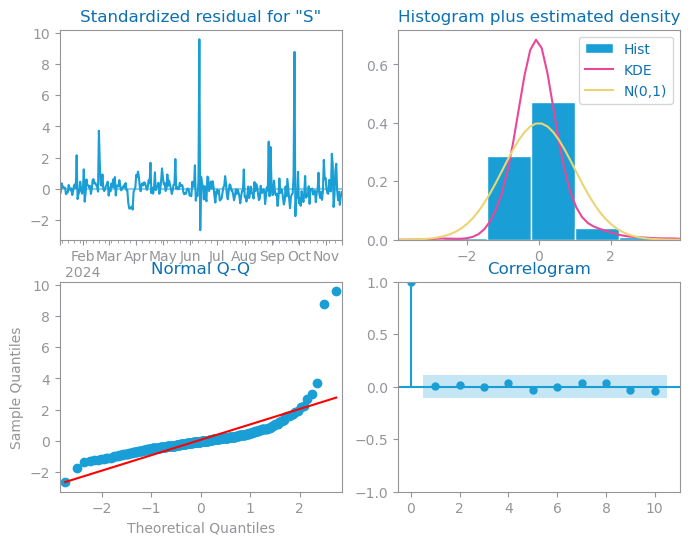

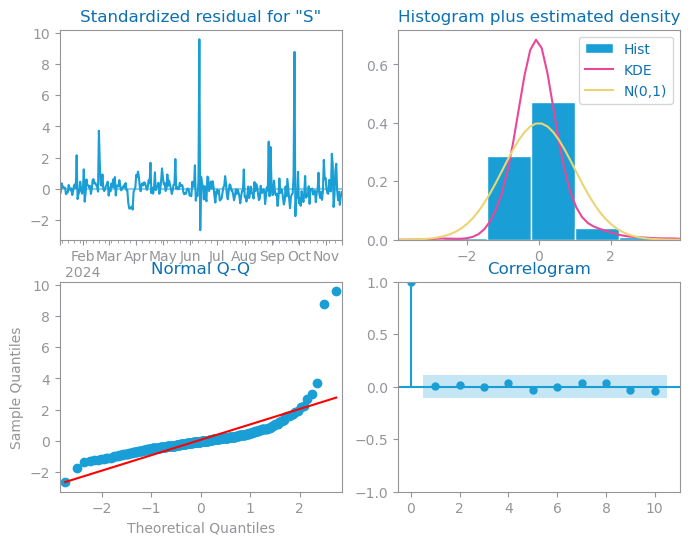

In [123]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Evaluate

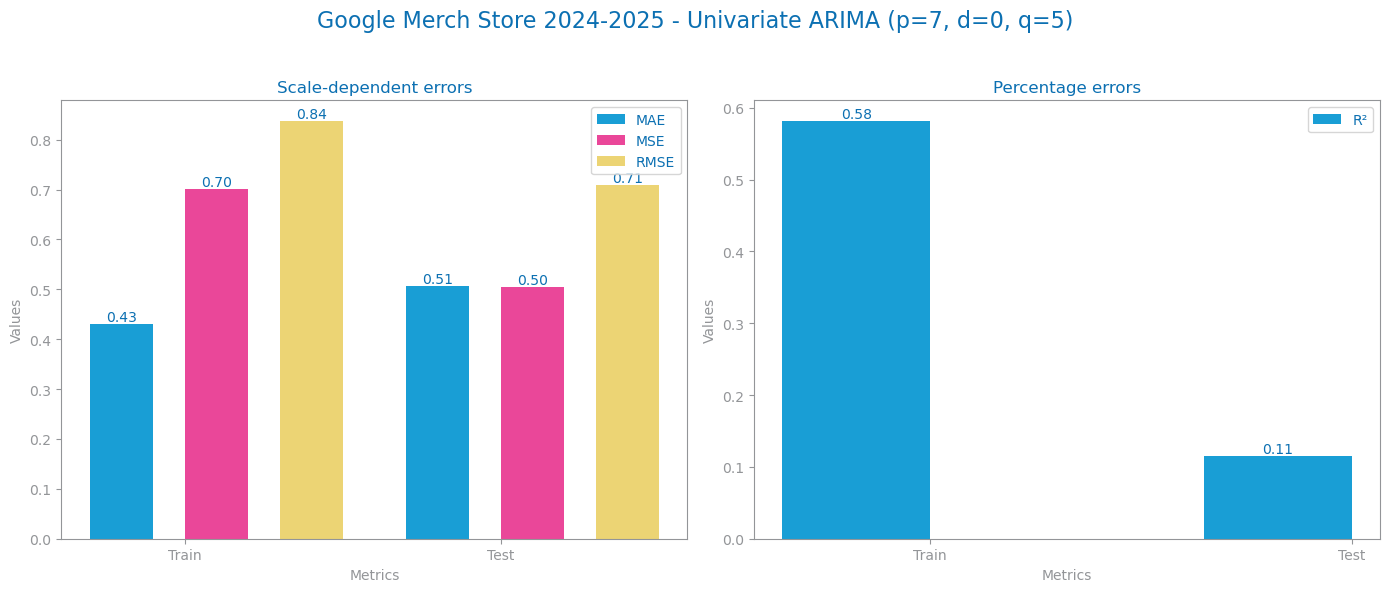

<Figure size 640x480 with 0 Axes>

In [127]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Univariate ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_univariate_eval.png")

## ARIMA Plot

<Axes: xlabel='Date', ylabel='Sessions'>

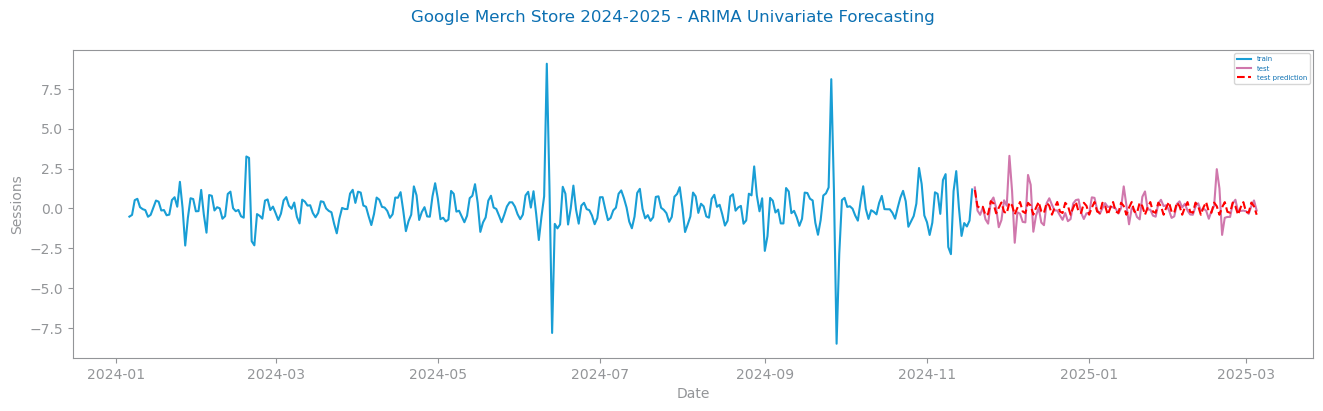

In [125]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - ARIMA Univariate Forecasting",
    xlabel='Date',
    ylabel=target,
)

# ARIMA Multivariate

## ARIMA Multivariate Study

ARIMA best results achieved with (p,d,q)=(1, 1, 5) ==> measure=0.78


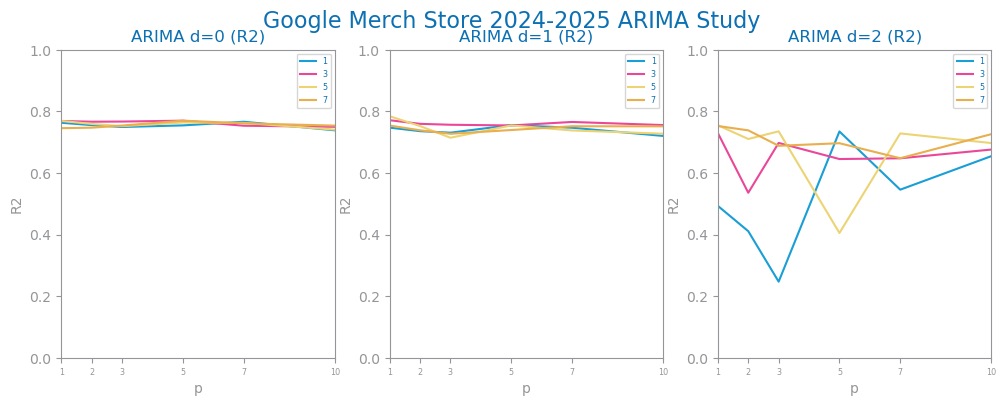

In [128]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart
from pandas import DataFrame
from numpy import isfinite
from statsmodels.tsa.arima.model import ARIMA
import warnings

def arima_multi_study(train: DataFrame, test: DataFrame, target: str, measure: str = "R2",freq: str = None):
    # Ensure data does not contain NaN or infinite values
    train = train[isfinite(train).all(axis=1)]
    test = test[isfinite(test).all(axis=1)]

    # Set frequency if provided
    if freq:
        train = train.asfreq(freq)
        test = test.asfreq(freq)


    trnY = train.pop(target)
    tstY = test.pop(target)
    trnX = train
    tstX = test

    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    fig.suptitle(f"{file_tag} ARIMA Study", fontsize=16)  # Add subtitle over the charts   
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                try:
                    arima = ARIMA(endog=trnY, exog=trnX, order=(p, d, q))
                    model = arima.fit(method_kwargs={"maxiter": 50})  # Increase the number of iterations
                    prd_tst = model.forecast(steps=len(tstY), exog=tstX)
                    eval: float = FORECAST_MEASURES[measure](tstY, prd_tst)
                    # print(f"ARIMA ({p}, {d}, {q})", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (p, d, q)
                        best_model = model
                    yvalues.append(eval)
                except Exception as e:
                    print(f"ARIMA ({p}, {d}, {q}) failed: {e}")
                    yvalues.append(None)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

measure='R2'

best_model, best_params = arima_multi_study(train, test, target=target, measure=measure, freq='D')
savefig(f"images/{file_tag}_arima_multivariate_{measure}_study.png")

## ARIMA Multivariate Model

In [129]:
from statsmodels.tsa.arima.model import ARIMA

best_params["params"]

predictor = ARIMA(endog=trnY, exog=trnX, order=(best_params["params"][0], best_params["params"][1], best_params["params"][2]))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               Sessions   No. Observations:                  318
Model:                 ARIMA(1, 1, 5)   Log Likelihood                  13.556
Date:                Sat, 22 Mar 2025   AIC                             76.887
Time:                        02:13:25   BIC                            272.350
Sample:                    01-06-2024   HQIC                           154.965
                         - 11-18-2024                                         
Covariance Type:                  opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Seven-day active users              0.0411      0.066      0.622      0.534      -0.088       0.171
28-day active users                 0.1369      0.178      0.769    

## ARIMA Multivariate Plot Diagnostics

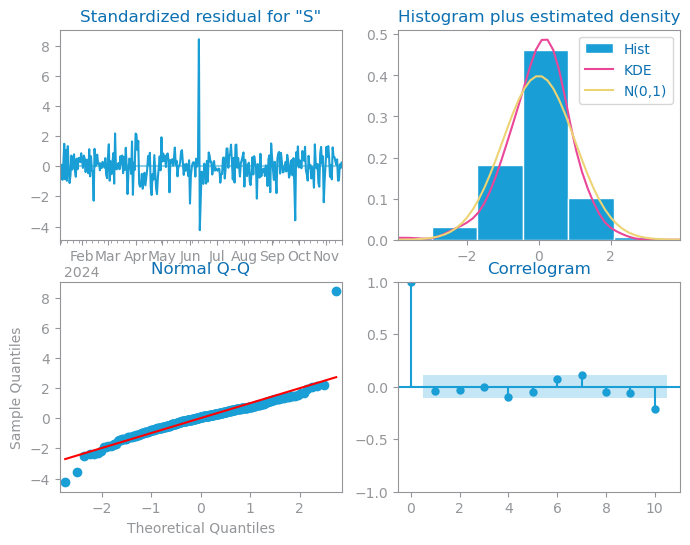

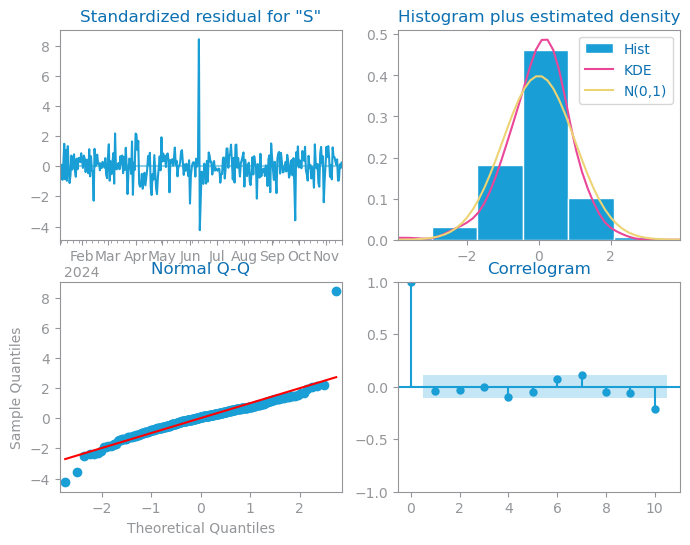

In [130]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Multivariate Evaluate

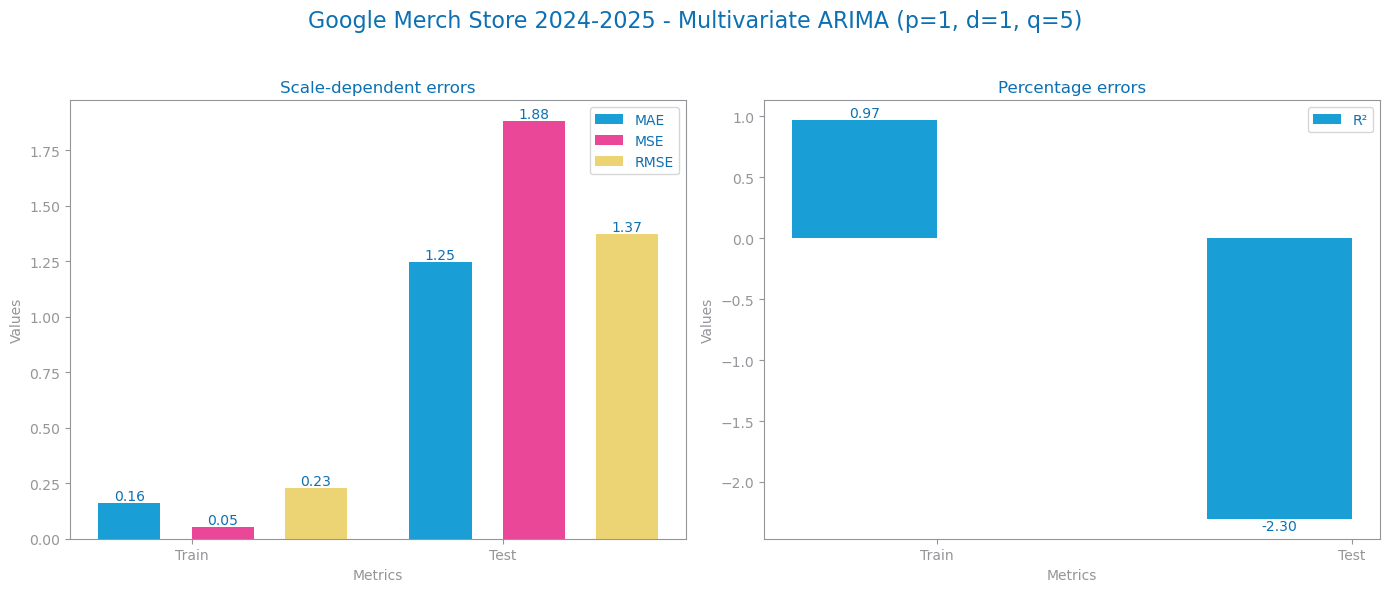

<Figure size 640x480 with 0 Axes>

In [131]:
from dslabs_functions import plot_forecasting_eval


params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)



# Use the last available exogenous variables from the training set for forecasting
last_exog = trnX.iloc[-1].values.reshape(1, -1)
exog_forecast = np.repeat(last_exog, len(test), axis=0)


prd_tst = best_model.forecast(steps=len(test), exog=exog_forecast)

plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Multivariate ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_multivariate_eval.png")

## ARIMA Multivariate Plot

<Axes: xlabel='Date', ylabel='Sessions'>

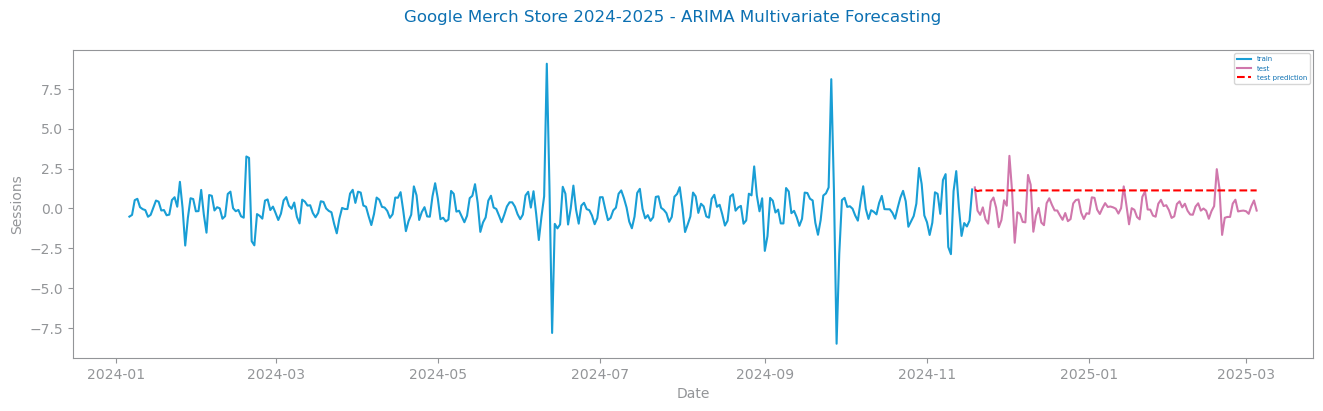

In [132]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - ARIMA Multivariate Forecasting",
    xlabel='Date',
    ylabel=target,
)